In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import models, transforms, datasets
from torchvision.io import read_image
import torchvision.transforms.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
print(device)

cuda


# Real time detection: SSD

In [ ]:
dir(models.detection)

['FCOS',
 'FCOS_ResNet50_FPN_Weights',
 'FasterRCNN',
 'FasterRCNN_MobileNet_V3_Large_320_FPN_Weights',
 'FasterRCNN_MobileNet_V3_Large_FPN_Weights',
 'FasterRCNN_ResNet50_FPN_V2_Weights',
 'FasterRCNN_ResNet50_FPN_Weights',
 'KeypointRCNN',
 'KeypointRCNN_ResNet50_FPN_Weights',
 'MaskRCNN',
 'MaskRCNN_ResNet50_FPN_V2_Weights',
 'MaskRCNN_ResNet50_FPN_Weights',
 'RetinaNet',
 'RetinaNet_ResNet50_FPN_V2_Weights',
 'RetinaNet_ResNet50_FPN_Weights',
 'SSD300_VGG16_Weights',
 'SSDLite320_MobileNet_V3_Large_Weights',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'anchor_utils',
 'backbone_utils',
 'faster_rcnn',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos',
 'fcos_resnet50_fpn',
 'generalized_rcnn',
 'image_list',
 'keypoint_rcnn',
 'keypointrcnn_resnet50_fpn',
 'mask_rcnn',
 'maskrcnn_resnet50_fpn'

In [ ]:
##
weights = models.detection.SSD300_VGG16_Weights.COCO_V1 # 91
ssd300 = models.detection.ssd300_vgg16(weights = weights)
ssd300

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
weights.transforms()

ObjectDetection()

ObjectDetection()

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(ssd300, (100, 3, 300, 300))

Layer (type:depth-idx)                   Output Shape              Param #
SSD                                      [96, 4]                   --
├─GeneralizedRCNNTransform: 1-1          [100, 3, 300, 300]        --
├─SSDFeatureExtractorVGG: 1-2            [100, 256, 1, 1]          512
│    └─Sequential: 2-1                   [100, 512, 38, 38]        --
│    │    └─Conv2d: 3-1                  [100, 64, 300, 300]       (1,792)
│    │    └─ReLU: 3-2                    [100, 64, 300, 300]       --
│    │    └─Conv2d: 3-3                  [100, 64, 300, 300]       (36,928)
│    │    └─ReLU: 3-4                    [100, 64, 300, 300]       --
│    │    └─MaxPool2d: 3-5               [100, 64, 150, 150]       --
│    │    └─Conv2d: 3-6                  [100, 128, 150, 150]      73,856
│    │    └─ReLU: 3-7                    [100, 128, 150, 150]      --
│    │    └─Conv2d: 3-8                  [100, 128, 150, 150]      147,584
│    │    └─ReLU: 3-9                    [100, 128, 150, 150]   

In [ ]:
## Preprocessing

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    # transforms.Normalize([0.48235, 0.45882, 0.40784], [0.00392156862745098, 0.00392156862745098, 0.00392156862745098])
])

In [ ]:
dataset = datasets.VOCDetection(
    "./",
    year = "2012",
    image_set = "val",
    download = True,
    transform = transform
)

torch.Size([3, 300, 300])


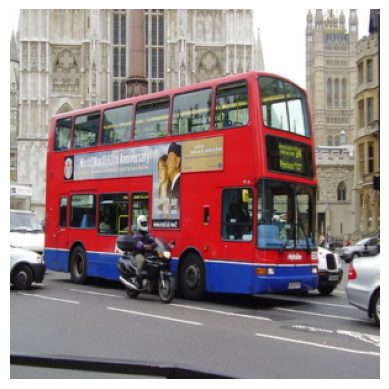

In [ ]:
idx = torch.randint(len(dataset), size = (1, ))
# idx

image, _ = dataset[idx.item()]
print(image.shape)

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()


In [ ]:
import time

idx = torch.randint(len(dataset), size = (1, ))
image, _ = dataset[idx.item()]
img = image.unsqueeze(0).to(device)
ssd300 = ssd300.to(device)
##
ssd300.eval()

start = time.time()

with torch.no_grad():
  prediction = ssd300(img)

stop = time.time()
print(f"estimation time = {(stop - start)*1000:.3f}")

prediction = prediction[0]

estimation time = 27.726


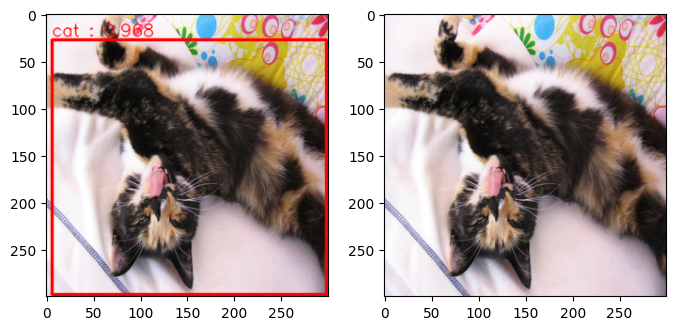

In [ ]:


image = img.cpu()[0]
image.shape
image = F.to_pil_image(image)
image = np.array(image)
image_rect = image.copy()
# image.shape

pred_boxes = prediction["boxes"]
pred_scores = prediction["scores"]
pred_labels = prediction["labels"]

threshold = 0.5

for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
  if score > threshold:
    box = list(map(int, box))
    cv2.rectangle(image_rect, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2,
                  cv2.LINE_AA)
    text = f"{weights.meta['categories'][label]} : {score:.3f}"
    cv2.putText(image_rect, text, (box[0], box[1]-4), 0, 0.6, (255, 0, 0),
                1, cv2.LINE_AA)

fig, axs = plt.subplots(1, 2,figsize = (8, 4))

axs[0].imshow(image_rect)
axs[1].imshow(image)
plt.show()

## SSD : Face detection

In [ ]:
# https://github.com/spmallick/learnopencv/tree/master/AgeGender

import sys
import cv2
import pandas as pd


In [ ]:


labels = ["img_id", "is_face", "confidence", "x1", "y1", "x2", "y2"]
out_df = pd.DataFrame(out[0][0], columns=labels)

# out_df.head()

,img_id,is_face,confidence,x1,y1,x2,y2
0,0.0,1.0,0.989431,0.825202,0.502988,0.893821,0.658601
1,0.0,1.0,0.950553,0.147596,0.511079,0.215222,0.681570
2,0.0,1.0,0.947276,0.288199,0.444965,0.359195,0.628823
3,0.0,1.0,0.920968,0.499137,0.392986,0.589955,0.570557
4,0.0,1.0,0.835135,0.642767,0.463616,0.720524,0.659535


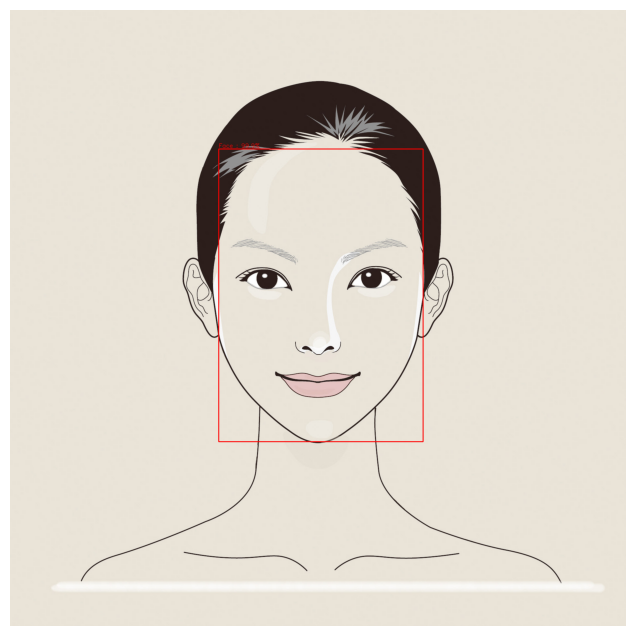

In [ ]:
# img = cv2.imread("/content/figure/king_face.png") #bgr
# img = cv2.imread("/content/figure/sunglass.png") #bgr
# img = cv2.imread("/content/figure/peoples.jpg") #bgr
img = cv2.imread("/content/figure/face_cartoon.jpg") #bgr


if img is None:
  print('image read failed')
  sys.exit()

model = "/content/opencv_face_detector_uint8.pb"
config = "/content/opencv_face_detector.pbtxt"

face_net = cv2.dnn.readNet(model, config)

if face_net.empty():
  print("Net open failed")
  sys.exit()

# blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop[, ddepth]]]]]]) -> retval
blob = cv2.dnn.blobFromImage(img, 1, (300, 300), (104, 177, 123), swapRB = False)

face_net.setInput(blob)
out = face_net.forward()

detect = out[0, 0, :, :] # [200, 7]
h, w = img.shape[:2]

for i in range(detect.shape[0]):

  confidence = detect[i, 2]

  if confidence > 0.5:
    x1 = int(detect[i, 3]*w)
    y1 = int(detect[i, 4]*h)
    x2 = int(detect[i, 5]*w)
    y2 = int(detect[i, 6]*h)

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    text = f"Face : {confidence*100:.1f}%"
    cv2.putText(img, text, (x1, y1 - 4), 0, 0.6, (0, 0, 255), 1, cv2.LINE_AA)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()


